## Importamos las librerias

In [ ]:
import numpy as np
from scipy import interpolate
import random
import matplotlib.pyplot as plt

## Definimos los datos iniciales de la pista

In [ ]:
# Datos iniciales de la pista
distancias = np.linspace(0, 300, 7)
alturas = [10, 60, 55, 70, 40, 50, 30]

## Creamos el spline cubico interpolando entre distancia y altura, y luego calculamos la curvatura

In [ ]:
# Creamos la spline cúbica
spline_cubica = interpolate.CubicSpline(distancias, alturas)
curvatura = spline_cubica.derivative(2)

## Definimos los puntos de la montaña rusa

In [ ]:
xSpline = np.linspace(0, 300, 400)
ySpline = spline_cubica(xSpline)

## Grafica Inicial

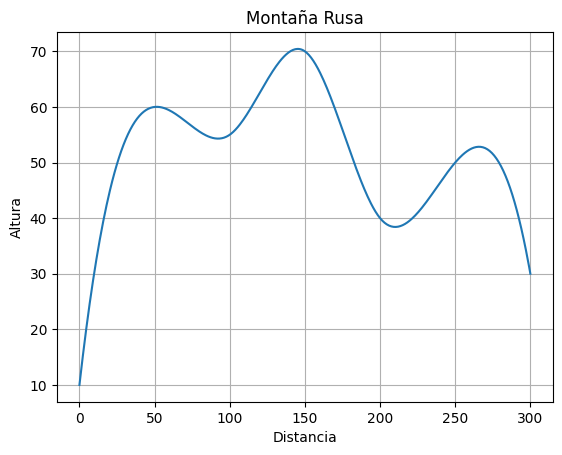

In [ ]:
plt.plot(xSpline,ySpline)
plt.title("Montaña Rusa")
plt.xlabel('Distancia')
plt.ylabel('Altura')
plt.grid(True)
plt.show()

## Definimos los parametros del algoritmo genetico

In [ ]:
# Parámetros del algoritmo genético
tamano_poblacion = 500  # Tamaño de la población reducido
num_generaciones = 1000  # Número de generaciones reducido
tasa_mutacion = 0.2  # Tasa de mutación
distancia_minima = 10  # Distancia mínima entre soportes
distancia_maxima = 20  # Distancia máxima entre soportes
num_soportes = 20  # Número de soportes
longitud_pista = 300  # Longitud total de la pista

## Funcion validar_individuo

Funcion que valida si un individuo es valido, tienen que respetar las condiciones de separacion entre cada uno, tiene que tener una longitud igual a la cantidad de soportes necesarios, y el ultimo soporte no debe estar colocado fuera de la pista. Ver comentarios para guiarse en el codigo.

In [ ]:
def validar_individuo(individuo, min_separacion, max_separacion):
    if len(individuo) != num_soportes: #si la longitud del individuo, es decir la cantidad de soportes, es distinta de la cantidad de soportes que necesitamos
        return False                   #el individuo no es valido
    for i in range(1, len(individuo)): # si las longitudes son iguales iteramos desde el segundo soporte al ultimo
        if not (min_separacion <= individuo[i] - individuo[i-1] <= max_separacion): #si la distancia entre un soporte y otro no cumple con las condiciones de separacion
            return False #el individuo no es valido
    return individuo[-1] <= 300 #pasando las 2 condiciones anteriores queda evaluar si el ultimo soporte no excede la longitud de la montaña, si cumple esta condicion el individuo es valido

## Funcion generar_individuo_valido

Generamos un individuo valido, un individuo es un conjunto de 20 soportes que respeten las condiciones de separacion entre ellos.

In [ ]:
# Función que genera un individuo válido con exactamente 20 soportes
def generar_individuo_valido(min_separacion, max_separacion, num_soportes): #Crea una disposición de soportes válida,
                                                                            #respetando las restricciones de separación.
    while True:
        individuo = [0]  # Partimos del primer soporte en
        for _ in range(1, num_soportes - 1):
            nuevo_soporte = individuo[-1] + np.random.uniform(min_separacion, max_separacion) #el nuevo soporte es igual al anterior
                                                                                              #sumado a una separacion random entre distancia minima y maxima
            if nuevo_soporte > 300: #cortamos cuando el nuevo soporte exceda los 300 metros
                break
            individuo.append(nuevo_soporte) #añadimos el nuevo soporte al individuo
        if len(individuo) == num_soportes - 1: # si la cantidad de soportes de nuestro individuo es igual a la cantidad de soportes que necesitamos -1 ...
            ultimo_soporte = min(individuo[-1] + np.random.uniform(min_separacion, max_separacion), 300) # generamos el ultimo soporte, haciendo la suma del anteultimo con una seperacion random
                                                                                                         # tomamos el minimo entre ese soporte y 300, por si se excede...
            individuo.append(ultimo_soporte)
            if validar_individuo(individuo, min_separacion, max_separacion): # validamos nuestro individuo
                return individuo #retornamos nuestro individuo valido

## Funcion calcular_aptitud

Definimos una funcion fitness que mide el promedio ponderado de las alturas de los soportes

In [ ]:
# Función para calcular el promedio ponderado (aptitud)
def calcular_aptitud(individuo):
    y = spline_cubica(individuo) #Calculamos la altura de los soportes para un individuo
    w = np.abs(curvatura(individuo)) #Calculamos los pesos utilizando los valores absolutos de la curvatura
    return np.sum(y * w) / np.sum(w) #queremos minimizar esto, el promedio ponderado

## Creamos una poblacion inicial

In [ ]:
# Inicialización de la población
poblacion = [generar_individuo_valido(distancia_minima, distancia_maxima, num_soportes) for _ in range(tamano_poblacion)]

## Grafica de la poblacion inicial

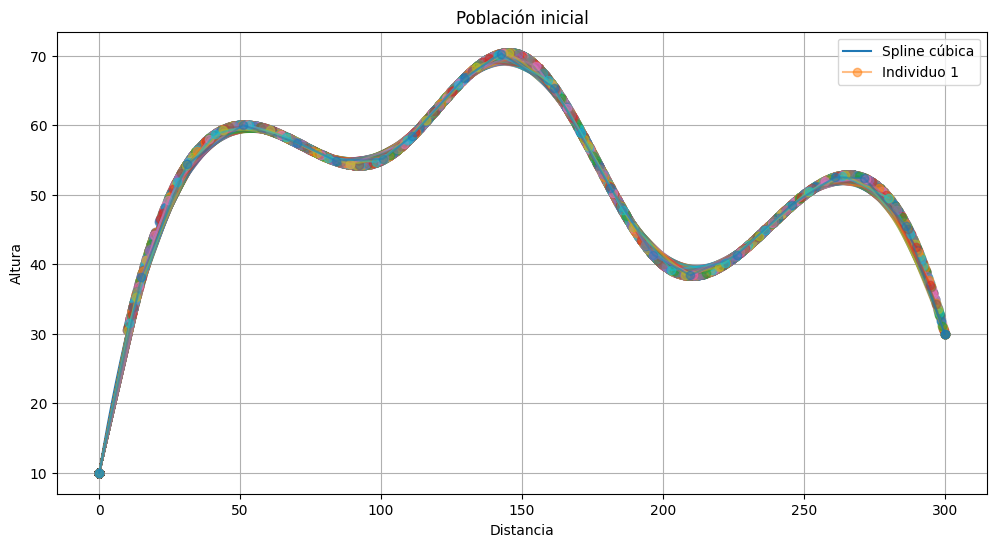

In [ ]:
# Graficar la población inicial antes de comenzar el bucle genético
plt.figure(figsize=(12, 6))
plt.plot(xSpline, ySpline, label='Spline cúbica')  # Graficar la curva de la pista

# Graficar los individuos de la población inicial
for idx, individuo in enumerate(poblacion):
    plt.plot(individuo, spline_cubica(individuo), 'o-', alpha=0.5, label=f'Individuo {idx+1}' if idx == 0 else "")  # Agregamos etiqueta solo para el primer individuo

plt.title("Población inicial")
plt.xlabel('Distancia')
plt.ylabel('Altura')
plt.grid(True)
plt.legend()
plt.show()

## Un poquito mas cerca...

Podemos observar toda la poblacion de individuos con sus soportes

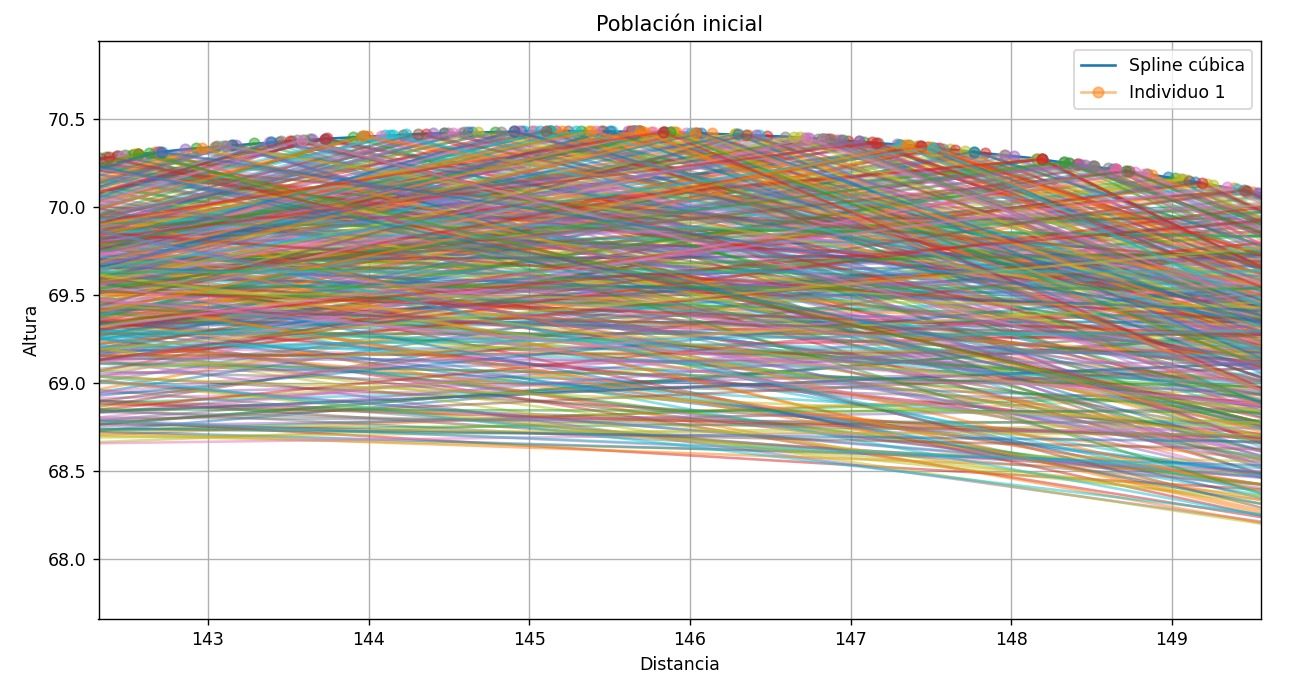

## Funcion crossover

Esta funcion toma dos individuos, parent1 y parent2. Luego definimos un punto de cruce al azar, lo que hacemos es definir un lugar específico donde los dos padres (es decir, los conjuntos de soportes de cada individuo) se van a "cortar". Esto divide a los padres en dos partes: una parte antes del punto de cruce y otra después.

Una vez cortados, las dos primeras partes de los padres se mantienen intactas, pero las segundas partes de los padres se intercambian, esta funcion la desglosamos para explicarla mejor.

In [ ]:
def crossover(parent1, parent2, min_separacion, max_separacion): #tomamos dos individuos, padres
    #bucle infinito hasta que se rompa o retorne algo
    while True:
        cross_point = np.random.randint(1, num_soportes - 1)  # random randint retorna un entero random, en este caso retorna un indice entre 1 y el anteultimo soporte

        #Se crea el primer hijo (child1):
        #Primero, se toma la primera parte del parent1 desde el inicio hasta el punto de cruce (cross_point).
        #Luego, se agrega una parte del parent2 desde el cross_point en adelante, pero solo los valores que
        #sean mayores que el último valor de la primera parte de parent1 (es decir, parent1[cross_point-1]), para mantener el orden de los soportes.

        child1 = parent1[:cross_point] + [x for x in parent2[cross_point:] if x > parent1[cross_point-1]]
        #Se crea el segundo hijo (child2) de manera similar al primer hijo:
        #Se toma la primera parte de parent2 hasta el punto de cruce y se combina con una parte de parent1 desde el punto de cruce en adelante,
        #pero solo los valores que sean mayores que el último valor de la primera parte de parent2 (parent2[cross_point-1]).
        child2 = parent2[:cross_point] + [x for x in parent1[cross_point:] if x > parent2[cross_point-1]]

        #Si el número de soportes en child1 es mayor que el número esperado (num_soportes):
        #Se eliminan soportes de manera aleatoria. Esto se hace seleccionando un índice aleatorio en el rango del 1 al tamaño actual de child1 - 1
        #(para no afectar los extremos) y se elimina el soporte en ese índice.

        while len(child1) > num_soportes:
            child1.pop(np.random.randint(1, len(child1)-1))

        #Si child1 tiene menos soportes de lo requerido, se insertan nuevos soportes:
        #Se elige un índice aleatorio en el rango del 1 al tamaño actual del child1 - 1, y en ese lugar se inserta un nuevo soporte que es el promedio del
        #soporte anterior (child1[idx-1]) y el siguiente (child1[idx]). Esto ayuda a mantener el orden y la separación entre los soportes.

        while len(child1) < num_soportes:
            idx = np.random.randint(1, len(child1)-1)
            child1.insert(idx, (child1[idx-1] + child1[idx]) / 2)

        #Mismo proceso para child2
        while len(child2) > num_soportes:
            child2.pop(np.random.randint(1, len(child2)-1))
        while len(child2) < num_soportes:
            idx = np.random.randint(1, len(child2)-1)
            child2.insert(idx, (child2[idx-1] + child2[idx]) / 2)
        #Validamos los hijos, y los retornamos
        if validar_individuo(child1, min_separacion, max_separacion) and validar_individuo(child2, min_separacion, max_separacion):
            return child1, child2

## Funcion mutate

Mutamos un individuo con una probabilidad prob de que los soportes sufran una mutacion,excepto el primero y el ultimo.

In [ ]:
def mutate(individuo, prob, min_separacion, max_separacion):
    for i in range(1, len(individuo) - 1):  # No mutamos el primer ni el último soporte

        #Se genera un número aleatorio entre 0 y 1. Si este número es menor que la probabilidad de mutación (prob), entonces se procede a mutar el soporte.
        if np.random.random() < prob:

            #Calcula la posición mínima a la que se puede mover el soporte i, asegurando que:
            #Esté por encima de la posición del soporte anterior más la separación mínima (individuo[i-1] + min_separacion).
            #No se aleje demasiado de su posición actual, considerando la separación máxima permitida.

            min_pos = max(individuo[i-1] + min_separacion, individuo[i] - (max_separacion - min_separacion))

            #Calcula la posición máxima a la que se puede mover el soporte i, asegurando que:
            #Esté por debajo de la posición del siguiente soporte menos la separación mínima (individuo[i+1] - min_separacion).
            #No se aleje demasiado de su posición actual, considerando la separación máxima permitida.
            max_pos = min(individuo[i+1] - min_separacion, individuo[i] + (max_separacion - min_separacion))

            #Si la posición mínima es menor que la máxima, se genera una nueva posición aleatoria para el soporte i dentro del rango permitido (min_pos a max_pos
            if min_pos < max_pos:
                individuo[i] = np.random.uniform(min_pos, max_pos)
    return individuo #retornamos el individuo mutado

## Bucle principal del algoritmo genético

In [ ]:
# Bucle principal del algoritmo genético
for gen in range(num_generaciones):
    fitness = []

    # Calcular el fitness de cada individuo
    for individuo in poblacion: # para cada individuo en nuestra poblacion
        fitness_value = calcular_aptitud(individuo) #calculamos el promedio pesado de las alturas
        fitness.append(1 / (fitness_value + 1e-6))  # Invertimos porque queremos minimizar

    fitness = np.array(fitness)
    fitness = fitness / fitness.sum()  # Normalizar fitness para usar en selección por probabilidad

    # Encontrar el mejor individuo de esta generación
    mejor_indice = np.argmax(fitness) # tomamos el indice del individuo con mejor fitness
    mejor_fitness = 1 / (fitness[mejor_indice] + 1e-6) - 1e-6 # Se calcula el fitness del mejor individuo de forma inversa para tener el valor original.

    if gen % 100 == 0:  # Imprimir progreso cada 100 generaciones
        print(f"Generación {gen}: Mejor fitness = {mejor_fitness:.2f}")

    # Crear la nueva generación
    offspring = [] #Inicializamos una lista offspring para almacenar los nuevos individuos (hijos)
    while len(offspring) < tamano_poblacion: #Iteramos mientras que la longitud de offspring sea menor al tamaño de la poblacion
        # np.random.choice selecciona al azar dos padres de la población,
        # utilizando las probabilidades de fitness para favorecer a los individuos más aptos.
        parents = np.random.choice(len(poblacion), 2, p=fitness)
        parent1 = poblacion[parents[0]]
        parent2 = poblacion[parents[1]]
        child1, child2 = crossover(parent1, parent2, distancia_minima, distancia_maxima) #cruzamos los individuos padres para generar a los hijos
        offspring.extend([child1, child2]) #añadimos los hijos a offspring

    # Aplicar mutación
    for i in range(len(offspring)):
         # Mutamos los hijos en offspring
        offspring[i] = mutate(offspring[i], tasa_mutacion, distancia_minima, distancia_maxima)
         # Se asegura de que el individuo siga siendo válido (cumpliendo las restricciones) después de la mutación.
        # Si no es válido, se genera un nuevo individuo válido.
        while not validar_individuo(offspring[i], distancia_minima, distancia_maxima):
            offspring[i] = generar_individuo_valido(distancia_minima, distancia_maxima, num_soportes)

    #Elitismo: mantener al mejor individuo
    #Se mantiene al mejor individuo de la población anterior en la nueva generación, colocándolo en la primera posición de offspring.
    offspring[0] = poblacion[mejor_indice]

    poblacion = offspring

Generación 0: Mejor fitness = 468.34
Generación 100: Mejor fitness = 458.77
Generación 200: Mejor fitness = 458.28
Generación 300: Mejor fitness = 457.61
Generación 400: Mejor fitness = 456.30
Generación 500: Mejor fitness = 456.30
Generación 600: Mejor fitness = 455.73
Generación 700: Mejor fitness = 454.97
Generación 800: Mejor fitness = 454.36
Generación 900: Mejor fitness = 454.07


## Grafica de los soportes y la montaña rusa

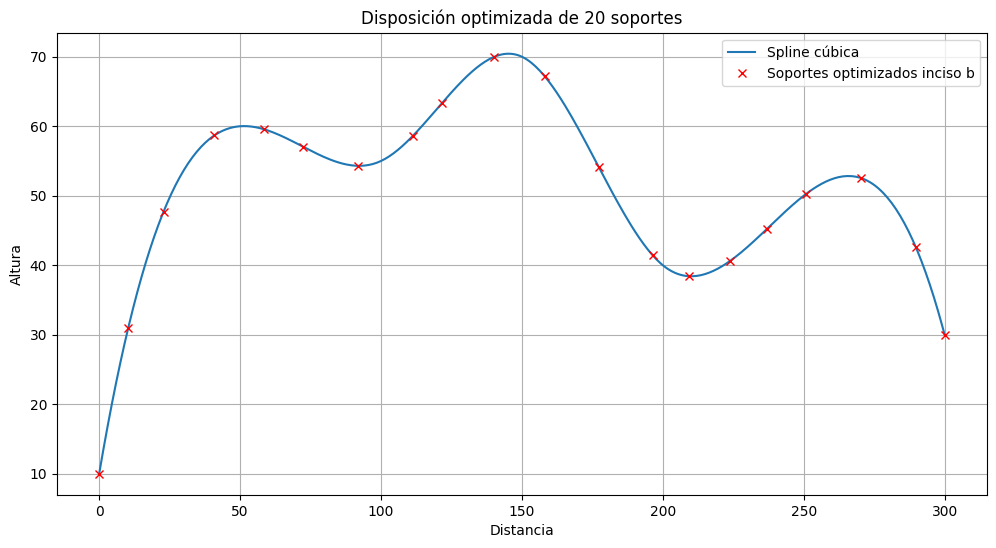

In [ ]:
# Encontrar el mejor individuo
mejor_individuo = poblacion[np.argmax(fitness)]

# Graficar la solución final
plt.figure(figsize=(12, 6))
plt.plot(xSpline, ySpline, label='Spline cúbica')
plt.plot(mejor_individuo, spline_cubica(mejor_individuo), 'rx', label='Soportes optimizados inciso b')
plt.xlabel('Distancia')
plt.ylabel('Altura')
plt.title('Disposición optimizada de 20 soportes')
plt.legend()
plt.grid(True)
plt.show()

## Datos de esta solución

In [ ]:
#defino funcion para calcular las alturas
def calcular_Alturas(individuo):
    return np.sum(spline_cubica(individuo))

# Imprimir la mejor solución encontrada
print("Mejor disposición de soportes:", mejor_individuo)
print("Número de soportes:", len(mejor_individuo))
print("Promedio pesado de las alturas:", calcular_aptitud(mejor_individuo))

# Verificar las separaciones
separaciones = np.diff(mejor_individuo)
print("Separaciones entre soportes:", separaciones)
print("Separación mínima:", np.min(separaciones))
print("Separación máxima:", np.max(separaciones))

Mejor disposición de soportes: [0, 10.281840036474247, 22.853482296452622, 40.903680272918635, 58.45600982026084, 72.42196023323432, 91.92943640814558, 111.32522997271332, 121.57964236479795, 139.9263573925274, 158.0600467112431, 177.25976453109243, 196.40380681977513, 209.4619826597287, 223.76238201259952, 236.90303795224264, 250.7045781329659, 270.29849249390355, 289.8097413302756, 300]
Número de soportes: 20
Promedio pesado de las alturas: 41.52745287829456
Separaciones entre soportes: [10.28184004 12.57164226 18.05019798 17.55232955 13.96595041 19.50747617
 19.39579356 10.25441239 18.34671503 18.13368932 19.19971782 19.14404229
 13.05817584 14.30039935 13.14065594 13.80154018 19.59391436 19.51124884
 10.19025867]
Separación mínima: 10.190258669724415
Separación máxima: 19.593914360937646
